In [1]:
import pandas as pd
import numpy as np
import glob
import os
import gc
import json 
import matplotlib.pyplot as plt

from multiprocessing import Pool
import multiprocessing

# num_cores = multiprocessing.cpu_count()
num_cores = 12
num_cores

from helpfuncs import *

In [2]:
# file to convert checkpoint to x,y 
pointsDdf=pd.read_csv('pointsDdf.csv')
pointsDdf.head()

,x,y,num
0,80.16,37.83,1
1,77.98,37.83,2
2,74.73,37.83,3
3,71.94,37.83,4
4,69.46,38.37,5


In [3]:
# Edit this cell appropriate if/where needed

raw_data_path="/home/gnas/IdealCities/data_collection_throttling/"

# MIN_OCCUR is minimum number of times a wifi must be present in whole dataset to be selected for modelling
# also mobile hotspots will be removed based on SSID name
MIN_OCCUR = 50

# MIN_CHECKPOINTS: Minumum number of checkpoint if file to include this file in dataset
MIN_CHECKPOINTS=3



In [4]:
all_filepaths = glob.glob(raw_data_path+"*.txt", recursive=True)
print('Total number of paths:',len(all_filepaths))

Total number of paths: 464


### File before wifi and sensor data records contains some info about the phone used for data collection.
### We need to separate this header from the rest data. 

In [5]:
# Reading the first file
for filepath in [all_filepaths[0]]:
    # read record
    with open(filepath, 'r') as f:
        content = f.readlines()
        f.close()
    n_header_rows = count_header_row(content)
    header = content[:n_header_rows]
    # arranged_header = to_dict(header)
    body = content[n_header_rows:-1]
    len_columns = 10
    columns = [f'column{i + 1}' for i in range(len_columns)]
    data = []
    for line in body:
        cleansed_line = separate_line_if_needed(line)  # data cleansing
        for line_ in cleansed_line:
            fields = [field for field in line_.strip().split('\t')]
            if len(fields) < len_columns:
                # padding
                fields += [np.nan] * (len_columns - len(fields))
            data.append(fields)
    arranged_body = pd.DataFrame(data=data, columns=columns)

In [6]:
arranged_body.head(10)

,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10
0,1633934463050,TYPE_GYROSCOPE,0.057114217,-0.060550235,0.0600921,3,NaN,NaN,NaN,NaN
1,1633934463050,TYPE_ROTATION_VECTOR,0.02550173,-0.62086284,-0.78178763,3,NaN,NaN,NaN,NaN
2,1633934463050,TYPE_ACCELEROMETER,0.32213375,9.477073,3.1106694,3,NaN,NaN,NaN,NaN
3,1633934463050,TYPE_MAGNETIC_FIELD,-0.93750006,-43.143753,7.05,1,NaN,NaN,NaN,NaN
4,1633934463050,TYPE_ACCELEROMETER_UNCALIBRATED,0.35353956,9.722038,1.7641085,0.0,0.0,0.0,3,NaN
5,1633934463050,TYPE_GYROSCOPE_UNCALIBRATED,0.05955761,-0.06024481,0.087274805,0.0024070654,2.818312E-4,0.027182959,3,NaN
6,1633934463050,TYPE_MAGNETIC_FIELD_UNCALIBRATED,-7.4625,-59.943752,52.95,-6.5260396,-16.783695,45.90095,3,NaN
7,1633934463100,TYPE_GYROSCOPE,0.051692948,-0.07765396,0.010689827,3,NaN,NaN,NaN,NaN
8,1633934463100,TYPE_ROTATION_VECTOR,0.02550173,-0.62086284,-0.78178763,3,NaN,NaN,NaN,NaN
9,1633934463100,TYPE_ACCELEROMETER,-0.38165522,9.307182,1.4635102,3,NaN,NaN,NaN,NaN


### For start we will only be using wifi sensor data.
### Use only wifis which occur many times throughout our dataset (>MIN_OCCUR)

In [7]:
# csvs_path = '/home/gnas/IdealCities/data_csvs_throttling/'
# Reading the first file
dfs=[]
dfsWP=[]
for filepath in all_filepaths:
    # read record
    with open(filepath, 'r') as f:
        content = f.readlines()
        f.close()
    n_header_rows = count_header_row(content)
    header = content[:n_header_rows]
    # arranged_header = to_dict(header)
    body = content[n_header_rows:-1]
    len_columns = 10
    columns = [f'column{i + 1}' for i in range(len_columns)]
    data = []
    for line in body:
        cleansed_line = separate_line_if_needed(line)  # data cleansing
        for line_ in cleansed_line:
            fields = [field for field in line_.strip().split('\t')]
            if len(fields) < len_columns:
                # padding
                fields += [np.nan] * (len_columns - len(fields))
            data.append(fields)
    df0 = pd.DataFrame(data=data, columns=columns)
    #     # write files
#     header_filepath=(filepath[:-3]+'txt').replace('data_collection_throttling/','data_headers_throttling/')
#     with open(header_filepath, 'w') as f:
#         f.writelines(header)
#         f.close()
        
#     body_filepath=(filepath[:-3]+'csv').replace('data_collection_throttling/','data_csvs_throttling/')
#     df0.to_csv(body_filepath, index=False)

    dfsWP.append(df0.loc[df0.column2=='TYPE_CHECKPOINT',:])

    df0 = df0.loc[df0.column2=='TYPE_WIFI',:]
    dfs.append(df0)
    gc.collect()

    
dfsWP = pd.concat(dfsWP)
dfsWP.reset_index(drop=True,inplace=True)        
#     value_counts = dfsWP.iloc[:,2].value_counts()

df = pd.concat(dfs)
df.reset_index(drop=True,inplace=True)        
value_counts = df.iloc[:,2].value_counts()

top_bssid = value_counts[value_counts > MIN_OCCUR].index.tolist()
    
    

print(len(top_bssid))

320


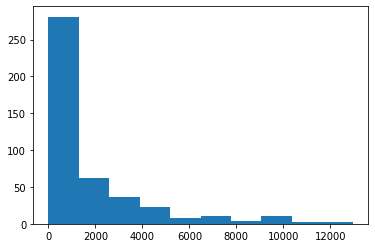

In [9]:
plt.hist( df.iloc[:,2].value_counts().values)
plt.show()

In [10]:
# df.iloc[:,2].value_counts()

In [11]:
df.shape

(729126, 10)

In [12]:
df.head()

,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10
0,1633934465112,TYPE_WIFI,78:72:5d:42:c6:4e,BU-WiFi,-43,5220,1633934446546,NaN,NaN,NaN
1,1633934465112,TYPE_WIFI,78:72:5d:42:c6:4c,eduroam,-43,5220,1633934446546,NaN,NaN,NaN
2,1633934465112,TYPE_WIFI,78:72:5d:42:c6:4b,_The Cloud,-44,5220,1633934446547,NaN,NaN,NaN
3,1633934465112,TYPE_WIFI,78:72:5d:42:c6:43,eduroam,-48,2437,1633934445935,NaN,NaN,NaN
4,1633934465112,TYPE_WIFI,78:72:5d:42:c6:40,BU-WiFi (Legacy),-48,2437,1633934445927,NaN,NaN,NaN


In [13]:
unwifis=df.column4.unique()
# unwifis

### Remove hotspots of mobile phones

In [14]:
mobileHotspots=['Android', 'Galaxy', 'iPhone', 'iphone', 'HUAWEI', 'Pixel_', 'Nokia', 'Honor']
newwifilist=unwifis.copy()
for hs in mobileHotspots:
    newwifilist = [x for x in newwifilist if hs not in str(x)]
# newwifilist

In [15]:
print(df.shape[0]- df.loc[df.column4.isin(newwifilist),:].shape[0],' records will be removed from data set')

2748  records will be removed from data set


In [16]:
df=df.loc[df.column4.isin(newwifilist),:].reset_index(drop=True)
value_counts = df.iloc[:,2].value_counts()

top_bssid = value_counts[value_counts > MIN_OCCUR].index.tolist()
print('Total number of different bssids in data set:',len(top_bssid))

Total number of different bssids in data set: 312


In [17]:
df.loc[:,['column1','column5','column6','column7']]=df.loc[:,['column1','column5','column6','column7']].astype(int)

In [18]:
df.dtypes

column1       int64
column2      object
column3      object
column4      object
column5       int64
column6       int64
column7       int64
column8      object
column9      object
column10    float64
dtype: object

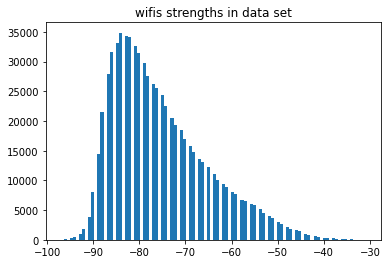

In [19]:
plt.hist(df.column5.values,100)
plt.title('wifis strengths in data set')
plt.show()

In [21]:
dfsWP.column3=dfsWP.column3.astype(int)

In [32]:
# df.loc[df.column2=='TYPE_CHECKPOINT']
a=dfsWP.groupby('column3', as_index=False).count().iloc[:,:2].sort_values('column1',ascending=False).reset_index(drop=True)
# a

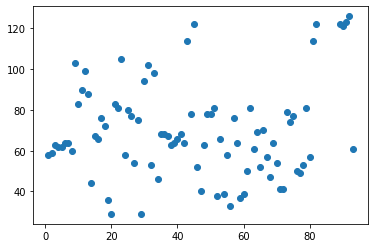

In [23]:
plt.plot(a.column3,a.column1,'o')
plt.show()

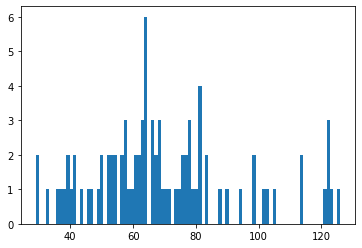

In [24]:
plt.hist(dfsWP.groupby('column3', as_index=False).count().iloc[:,:2].sort_values('column1',ascending=False).reset_index().column1.values,90)
plt.show()

In [25]:
# import matplotlib.pyplot as plt
# plt.hist(value_counts, 50)
# plt.show()

In [26]:
bssid={}
bssid['Building0_floor0'] = top_bssid

In [27]:
with open("bssid_"+str(MIN_OCCUR)+"_getWifisFromText.json", "w") as f:
    json.dump(bssid, f)

with open("bssid_"+str(MIN_OCCUR)+"_getWifisFromText.json") as f:
    bssid = json.load(f)
    
# with open("bssid_"+str(MIN_OCCUR)+"_clean.json") as f:
#     bssid = json.load(f)

### Create dataset
### Use only wifis from newwifilist
### Don't use files with num checkpoints less than MIN_CHECKPOINTS

In [28]:
index = sorted(bssid['Building0_floor0'])
# files = os.listdir(csvs_path)
dfs=[]
# for file in files:
for filepath in all_filepaths:    
#     df0 = pd.read_csv(csvs_path+file)
    with open(filepath, 'r') as f:
        content = f.readlines()
        f.close()
    n_header_rows = count_header_row(content)
    header = content[:n_header_rows]
    # arranged_header = to_dict(header)
    body = content[n_header_rows:-1]
    len_columns = 10
    columns = [f'column{i + 1}' for i in range(len_columns)]
    data = []
    for line in body:
        cleansed_line = separate_line_if_needed(line)  # data cleansing
        for line_ in cleansed_line:
            fields = [field for field in line_.strip().split('\t')]
            if len(fields) < len_columns:
                # padding
                fields += [np.nan] * (len_columns - len(fields))
            data.append(fields)
    df0 = pd.DataFrame(data=data, columns=columns)
    
    # Correct wifi times if needed 
    df0.loc[df0.column2=='TYPE_WIFI','column1']=np.nan
    df0.loc[:,'column1'].fillna(method='ffill',inplace=True)
    df0.column1=df0.column1.astype(int)
    
    df = df0.loc[df0.column2=='TYPE_WIFI',:]
    df_wp = df0.loc[df0.column2=='TYPE_CHECKPOINT',:]

    # only use data in wifilist - exclude mobile phones and wifis with few occurrences
    df=df.loc[df.column4.isin(newwifilist),:].reset_index(drop=True)
    
    # If number of checkpoint in file is less than min, don't include this file
    if len(df_wp)<MIN_CHECKPOINTS:
        continue


    # generate a feature, and label for each wifi block
    for gid, g in df.groupby('column1'):
        dists = list()
#                 for e, k in enumerate(df_wp):
        for k in range(len(df_wp)):
            dist = abs(int(gid) - int(df_wp.iloc[k,0]))
#                     dist = abs(int(gid) - int(k[0]))
            dists.append(dist)
        nearest_wp_index = np.argmin(dists)

        g = g.drop_duplicates(subset='column3')
        tmp = g.iloc[:,[2,4]]
        feat = tmp.set_index('column3').reindex(index).replace(np.nan, -999).T

        feat["x"] = float(pointsDdf.x.loc[pointsDdf.num==int(df_wp.iloc[nearest_wp_index,2])].values[0])
        feat["y"] = float(pointsDdf.y.loc[pointsDdf.num==int(df_wp.iloc[nearest_wp_index,2])].values[0]) 
        
        feat["timestamp"] = int(gid)
        feat["gs"] =  ''.join([x[0] for x in g.column6.astype('int').astype('str').values.tolist()])
#         feat["f"] = floor
#         feat["path"] = file.split('.')[0] # useful for crossvalidation
        feat["path"] = filepath.split('/')[-1].split('.')[0] # useful for crossvalidation
    
        dfs.append(feat)
#     break
building_df = pd.concat(dfs)
building_df.reset_index(drop=True, inplace=True)
#     building_dfs[building] = df
# building_df.to_csv(SAVEDIR+building+"_"+str(MIN_OCCUR)+"_train.csv")

### Save dataset in disk

In [29]:
building_df.to_csv("Building0"+str(MIN_OCCUR)+"_getWifisFromText.csv")

In [30]:
building_df.head()

column3,00:12:5f:0a:9e:e6,00:12:5f:10:05:64,00:12:5f:12:0b:ce,00:33:bb:1e:4f:56,00:b7:71:00:46:a0,00:b7:71:00:46:a3,00:b7:71:00:46:a4,00:b7:71:00:46:ab,00:b7:71:00:46:ac,00:b7:71:00:46:ae,...,f4:db:e6:3e:8c:e4,f4:db:e6:3e:8c:eb,f4:db:e6:3e:8c:ec,f4:db:e6:3e:8c:ee,f8:9a:78:63:cf:07,x,y,timestamp,gs,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,5552225552255555522252225522222222225552555555...,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,5552225552255555522252225522222222225552555555...,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,55522255555525222222255252552525552252,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,55522255555525222222255252552525552252,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,55522255522222555555222552222222,record_2021_10_11_07_41_02


In [31]:
building_df.shape

(14373, 317)